# Este notebook foi executado na plataforma Kaggle, pois lá oferece uma GPU e uma maior quantidade de memória.

In [2]:
import pandas as pd
import numpy as np

import random
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", UserWarning)
pd.set_option('mode.chained_assignment', None)
seed = 7
np.random.seed(seed)


Using TensorFlow backend.


# O objetivo deste notebook é treinar uma rede neural LSTM para a resolução do problema.
* Resultados:
* * Este modelo obtve uma acurácia final de 0.86, entretanto, um loss bastante alto.
* * Possíveis soluções? Utilizar uma rede bidireconal com o Glove.

# Leitura dos dados

In [4]:
df = pd.read_csv("Outputs/data1.csv", sep=",")

In [5]:
df.head(10)

,Unnamed: 0,Id,IdSentenca,Texto,Sentimento
0,0,1,1,series escapades demonstrating adage good goos...,1
1,1,2,1,series escapades demonstrating adage good goose,2
2,2,3,1,series,2
3,4,5,1,series,2
4,5,6,1,escapades demonstrating adage good goose,2
5,7,8,1,escapades demonstrating adage good goose,2
6,8,9,1,escapades,2
7,9,10,1,demonstrating adage good goose,2
8,10,11,1,demonstrating adage,2
9,11,12,1,demonstrating,2


# Preparando os dados e os parâmetros para a rede

In [24]:
# dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50
# número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 300
# Reflete a quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 5000
# dimensão de saída da camada Embedding
embed_dim = 128
# limitamos o tamanho máximo de todas as sentenças
max_sequence_length = 300


def prepare_data(data, label = None, test=False):    

    
    text = []
    for row in data['Texto'].values:
        text.append(row)

    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    
    X = pad_sequences(X, maxlen=max_sequence_length)
    #X = pad_sequences(X)

    word_index = tokenizer.word_index
    #Y = pd.get_dummies(data[label]).values
    
    Y = pd.get_dummies(data["Sentimento"].values)
    if test == True:
        return X, word_index, tokenizer
    else:
        #Y = pd.get_dummies(data[labels]).values
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
    
        X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.10, random_state = 42)
        return X_train, X_test, Y_train, Y_test, word_index, X_val, Y_val, tokenizer



# Definição do modelo
* Uma camada de embedding
* Uma LSTM

In [25]:
def model():  
    input_shape = (max_sequence_length,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')    
    embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)   
    lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    
    model_output = Dense(5, activation='sigmoid', name="sigmoid")(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    return model

# Treinamento e Plot dos gráficos

In [26]:
def train(model, X_train, Y_train, X_val, Y_val):

    history = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_val, Y_val),
        epochs=20,
        batch_size=3000, 
        shuffle=True,
        verbose=1)  

    # Plot
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    return model


(111330, 300) (111330, 5)
(30925, 300) (30925, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
sigmoid (Dense)              (None, 5)                 645       
Total params: 772,229
Trainable params: 772,229
Non-trainable params: 0
_________________________________________________________________
None
Train on 111330 samples, validate on 12370 samples
Epoch 1/20
111330/111330 [==============================] - 33s 294us/step - loss: 0.4756 - acc: 0.7969 - val_loss: 0.4148 - val_acc: 0.8300
Epoch 2/20
111330/111

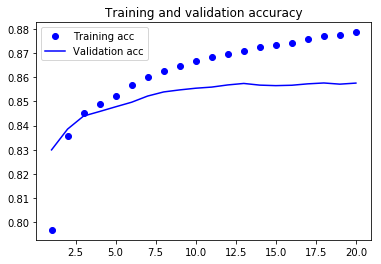

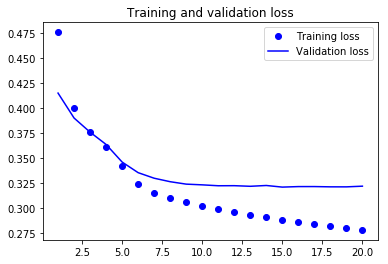

In [27]:

X_train, X_test, Y_train, Y_test, word_index, X_val, Y_val, tokenizer = prepare_data(df)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
    
model = model()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())
model = train(model, X_train, Y_train, X_val, Y_val)    
y_pred = model.predict(X_test,batch_size=1024,verbose=5)


In [28]:
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=1000)

30925/30925 [==============================] - 7s 231us/step


# Loss e acurácia para o teste



In [45]:
data = {'Loss': loss, 'Accuracy': accuracy}
pd.DataFrame(data, columns=["Loss", "Accuracy"], index=[0])

,Loss,Accuracy
0,0.320693,0.859512
